In [80]:
import numpy as np
import pandas as pd

In [81]:
from helper import *

In [82]:
# ! pip install pandas nltk gensim pyldavis
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [83]:
df=pd.read_csv("turkish_news_70000.csv", index_col="id")
df.head()

,main_image,published,site,text,title,url
id,,,,,,
72337,"""http://www.diken.com.tr/wp-content/uploads/20...","""2019-03-04T13:33:00.000+02:00""","""diken.com.tr""","""Yatırım bankası: Dolar/TL üçüncü çeyrekte 8.9...","""Yatırım bankası: Dolar/TL üçüncü çeyrekte 8.9...","""http://www.diken.com.tr/yatirim-bankasi-dolar..."
72338,"""http://www.diken.com.tr/wp-content/uploads/20...","""2019-03-04T13:21:00.000+02:00""","""diken.com.tr""","""PİAR Araştırma: Adana ve Antalya’da ‘millet i...","""PİAR Araştırma: Adana ve Antalya’da ‘millet i...","""http://www.diken.com.tr/piar-arastirma-adana-..."
72339,"""http://www.diken.com.tr/wp-content/uploads/20...","""2019-03-04T12:20:00.000+02:00""","""diken.com.tr""","""Renaissance Capital: Merkez Bankası bu hafta ...","""Renaissance Capital: Merkez Bankası bu hafta ...","""http://www.diken.com.tr/renaissance-capital-m..."
72340,"""http://www.diken.com.tr/wp-content/uploads/20...","""2019-03-04T11:53:00.000+02:00""","""diken.com.tr""","""Ağrı’daki İYİ Partililerin istifa gerekçesi: ...","""Ağrı’daki İYİ Partililerin istifa gerekçesi: ...","""http://www.diken.com.tr/agridaki-iyi-partilil..."
72341,"""http://www.diken.com.tr/wp-content/uploads/20...","""2019-03-04T11:52:00.000+02:00""","""diken.com.tr""","""Otomobil pazarı iki ayda yarı yarıya eridi 04...","""Otomobil pazarı iki ayda yarı yarıya eridi""","""http://www.diken.com.tr/otomobil-pazari-iki-a..."


In [84]:
haber_veriseti=df[["text"]][:10000]
haber_veriseti.head() ## LDA modelinde sadece text sütunu kullanılacaktır.

,text
id,
72337,"""Yatırım bankası: Dolar/TL üçüncü çeyrekte 8.9..."
72338,"""PİAR Araştırma: Adana ve Antalya’da ‘millet i..."
72339,"""Renaissance Capital: Merkez Bankası bu hafta ..."
72340,"""Ağrı’daki İYİ Partililerin istifa gerekçesi: ..."
72341,"""Otomobil pazarı iki ayda yarı yarıya eridi 04..."


### Data pre-processing

In [85]:
import re
import string
import nltk
from nltk.corpus import stopwords

In [86]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Sevda
[nltk_data]     Sezer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [87]:
nok_set=string.punctuation

In [88]:
stopwords_set=stopwords.words("turkish") #stopwords kümesine biz de istediğimiz kelimeleri ekleyebiliriz.
#etkisiz_kelimeler_kümesi

In [89]:
stopwords_set.extend(["bir","kadar","sonra"])
#etkisiz_kelimeler_kümesi

In [90]:
def veri_temizleme(metin):
    #metindeki tüm kelimeleri küçük duruma getirir.
    metin=metin.lower()
    # veri setinde ki yeni satır karakterini (\n) boşluk karakteri ile değiştirdik.
    metin=metin.replace("\\n"," ")
    #kesme isareti ve sonrasında ki karakterlerin kaldırılması
    metin=re.sub("’(\w+)","",metin)
    metin=re.sub("'(\w+)","",metin)
    metin=re.sub("[“,”,‘,’]","",metin)
    #sayıların kaldırılması
    metin=re.sub("[0-9]+","",metin)
    #noktalama işaretlerinin kaldırılması
    metin="".join(list(map(lambda x:x if x not in nok_set else " ", metin)))
    #etkisiz kelimelerin bir kısmının kaldırılması
    metin=" ".join([i for i in metin.split() if i not in stopwords_set])
    #metin de tek kalan harflerin çıkarılması
    metin=" ".join([i for i in metin.split() if len(i)>1])
    
    return metin

In [91]:
haber_veriseti["temizlenen_metin"]=haber_veriseti["text"].apply(veri_temizleme)

In [92]:
haber_veriseti

,text,temizlenen_metin
id,,
72337,"""Yatırım bankası: Dolar/TL üçüncü çeyrekte 8.9...",yatırım bankası dolar tl üçüncü çeyrekte görec...
72338,"""PİAR Araştırma: Adana ve Antalya’da ‘millet i...",pi̇ar araştırma adana antalya millet ittifakı ...
72339,"""Renaissance Capital: Merkez Bankası bu hafta ...",renaissance capital merkez bankası hafta baz p...
72340,"""Ağrı’daki İYİ Partililerin istifa gerekçesi: ...",ağrı i̇yi̇ partililerin istifa gerekçesi akp s...
72341,"""Otomobil pazarı iki ayda yarı yarıya eridi 04...",otomobil pazarı iki ayda yarı yarıya eridi oto...
...,...,...
82331,"""Sağlıkle Beslenmede Efsane ve Gerçekler Sağlı...",sağlıkle beslenmede efsane gerçekler sağlıkle ...
82332,"""A Yazı Tipi Tarım ve Orman Bakanı Bekir Pakde...",yazı tipi tarım orman bakanı bekir pakdemirli ...
82333,"""A Yazı Tipi Askerlik görevini ertelemek istey...",yazı tipi askerlik görevini ertelemek isteyen ...


In [93]:
haber_veriseti.iloc[5].text

'"Şubat ayında ihracat yüzde 3.7 arttı, ithalat yüzde 18.7 azaldı 04/03/2019 12:20\\nTicaret Bakanı Ruhsar Pekcan şubat ayında ihracatın yüzde 3.7 artışla 14 milyar 312 milyon dolar, ithalatın yüzde 18.7 azalışla 16 milyar 161 milyon dolar olarak gerçekleştiğini açıkladı. Fotoğraf: Reuters\\nBakan Pekcan şunları söyledi: “ Eskiden kullandığımız Özel Ticaret Sistemine göre de şubat ayında ihracatımız yüzde 3,5 artışla 13 milyar 603 milyon dolar olarak gerçekleşmiştir. ÖTS’ye göre ithalatımız şubat ayında yüzde 16,6 düşüşle 15 milyar 793 milyon dolar seviyesinde gerçekleşmiştir. ” Reklam"'

In [94]:
haber_veriseti.iloc[5].temizlenen_metin

'şubat ayında ihracat yüzde arttı ithalat yüzde azaldı ticaret bakanı ruhsar pekcan şubat ayında ihracatın yüzde artışla milyar milyon dolar ithalatın yüzde azalışla milyar milyon dolar olarak gerçekleştiğini açıkladı fotoğraf reuters bakan pekcan şunları söyledi eskiden kullandığımız özel ticaret sistemine göre şubat ayında ihracatımız yüzde artışla milyar milyon dolar olarak gerçekleşmiştir öts göre ithalatımız şubat ayında yüzde düşüşle milyar milyon dolar seviyesinde gerçekleşmiştir reklam'

In [95]:
haber_veriseti["temizlenen_metin_token"]=haber_veriseti["temizlenen_metin"].apply(lambda x: x.split())

In [96]:
# temizlenen ve tokenize edilen metinleri de haber_veriseti dataframe'ne eklemiş olduk
haber_veriseti.head(10)

,text,temizlenen_metin,temizlenen_metin_token
id,,,
72337,"""Yatırım bankası: Dolar/TL üçüncü çeyrekte 8.9...",yatırım bankası dolar tl üçüncü çeyrekte görec...,"[yatırım, bankası, dolar, tl, üçüncü, çeyrekte..."
72338,"""PİAR Araştırma: Adana ve Antalya’da ‘millet i...",pi̇ar araştırma adana antalya millet ittifakı ...,"[pi̇ar, araştırma, adana, antalya, millet, itt..."
72339,"""Renaissance Capital: Merkez Bankası bu hafta ...",renaissance capital merkez bankası hafta baz p...,"[renaissance, capital, merkez, bankası, hafta,..."
72340,"""Ağrı’daki İYİ Partililerin istifa gerekçesi: ...",ağrı i̇yi̇ partililerin istifa gerekçesi akp s...,"[ağrı, i̇yi̇, partililerin, istifa, gerekçesi,..."
72341,"""Otomobil pazarı iki ayda yarı yarıya eridi 04...",otomobil pazarı iki ayda yarı yarıya eridi oto...,"[otomobil, pazarı, iki, ayda, yarı, yarıya, er..."
72342,"""Şubat ayında ihracat yüzde 3.7 arttı, ithalat...",şubat ayında ihracat yüzde arttı ithalat yüzde...,"[şubat, ayında, ihracat, yüzde, arttı, ithalat..."
72343,"""YSK Başkanı Güven'den 'seçim güvenliği' açıkl...",ysk başkanı güven güvenliği açıklaması şubat c...,"[ysk, başkanı, güven, güvenliği, açıklaması, ş..."
72344,"""Hapisten çıkmasın diye kızları intihara kalkı...",hapisten çıkmasın kızları intihara kalkışmıştı...,"[hapisten, çıkmasın, kızları, intihara, kalkış..."
72345,"""Yavaş’tan Özhaseki’ye: Tecrübeyse, Gökçek dah...",yavaş özhaseki tecrübeyse gökçek tecrübeliydi ...,"[yavaş, özhaseki, tecrübeyse, gökçek, tecrübel..."


In [97]:
import gensim
import pyLDAvis.gensim #LDA konu modellemesi igürsel gösterimi için kullanılan kütüphane

In [98]:
#kelime listesi - Dictionary oluşturulması
tokenlastirilmis_metinler=haber_veriseti["temizlenen_metin_token"]
kelime_listesi=gensim.corpora.Dictionary(tokenlastirilmis_metinler)

#kelime listesi filtreleme
kelime_listesi.filter_extremes(no_below=1,no_above=0.7)


In [99]:
kelime_listesi.save('dictionary.dict')
kelime_listesi

In [100]:
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
#Terimlerin vektörleştirilmesi -- Döküman Terim matrisinin oluşturulması
doc_term_matrix = [kelime_listesi.doc2bow(doc) for doc in tokenlastirilmis_metinler]
corpora.MmCorpus.serialize('corpus.mm', doc_term_matrix)

print (len(doc_term_matrix))
print (doc_term_matrix[100])

10000
[(1, 1), (13, 1), (27, 1), (29, 2), (57, 1), (58, 1), (65, 2), (66, 1), (77, 1), (82, 1), (84, 8), (99, 2), (112, 5), (129, 3), (137, 8), (139, 3), (140, 1), (145, 4), (237, 1), (269, 3), (275, 1), (306, 1), (308, 2), (346, 1), (367, 4), (378, 2), (409, 1), (416, 1), (418, 1), (433, 1), (470, 1), (496, 1), (513, 1), (532, 1), (554, 3), (555, 1), (728, 1), (729, 1), (736, 1), (740, 1), (741, 2), (747, 1), (751, 2), (754, 2), (785, 1), (908, 1), (920, 2), (929, 1), (938, 1), (970, 2), (991, 3), (992, 1), (994, 2), (1040, 2), (1050, 3), (1066, 1), (1197, 3), (1306, 1), (1394, 1), (1447, 1), (1459, 1), (1592, 1), (1617, 2), (1624, 4), (1698, 1), (1704, 1), (1778, 2), (1811, 1), (1876, 1), (1963, 2), (2141, 1), (2212, 2), (2315, 2), (2333, 1), (2437, 7), (2579, 1), (2601, 2), (2883, 3), (2929, 1), (2987, 1), (3076, 1), (3095, 1), (3206, 1), (3241, 1), (3369, 1), (3460, 1), (3476, 1), (3561, 1), (3595, 1), (3667, 1), (3693, 2), (3782, 2), (3837, 1), (3944, 1), (4089, 1), (4223, 2), (43

In [101]:
from time import time
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO,
                   filename='running.log',filemode='w')

In [64]:
# Creating the object for LDA model using gensim library


#LDA model
#lda_model=gensim.models.ldamodel.LdaModel(corpus=dokuman_terim_matrisi,
                                         #id2word=kelime_listesi,
                                        # num_topics=15,
                                     #    passes=10)

# Running and Trainign LDA model on the document term matrix.
start = time()
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=15, id2word = kelime_listesi, passes=10)
print ('used: {:.2f}s'.format(time()-start))

used: 195.10s


In [65]:
print(ldamodel.print_topics(num_topics=2, num_words=4))

[(5, '0.022*"parti" + 0.017*"belediye" + 0.015*"ak" + 0.015*"chp"'), (6, '0.019*"i̇stanbul" + 0.014*"bin" + 0.009*"yer" + 0.007*"hava"')]


In [67]:
for i in ldamodel.print_topics(): 
    for j in i: 
        print(j)

0
0.008*"ilk" + 0.007*"son" + 0.007*"fenerbahçe" + 0.005*"oldu" + 0.005*"iyi" + 0.005*"beşiktaş" + 0.005*"olan" + 0.004*"galatasaray" + 0.004*"takım" + 0.004*"iki"
1
0.022*"pakistan" + 0.020*"hindistan" + 0.017*"huawei" + 0.016*"petrol" + 0.011*"xx" + 0.009*"hava" + 0.008*"telefon" + 0.008*"keşmir" + 0.006*"varil" + 0.006*"kamera"
2
0.008*"olarak" + 0.008*"olan" + 0.004*"dr" + 0.004*"önemli" + 0.004*"fazla" + 0.003*"farklı" + 0.003*"olduğu" + 0.003*"ancak" + 0.003*"üniversitesi" + 0.003*"özellikle"
3
0.015*"var" + 0.007*"değil" + 0.007*"ben" + 0.006*"türkiye" + 0.006*"yok" + 0.005*"bizim" + 0.005*"bunu" + 0.005*"zaman" + 0.005*"erdoğan" + 0.004*"büyük"
4
0.050*"yüzde" + 0.024*"milyon" + 0.021*"bin" + 0.019*"milyar" + 0.017*"göre" + 0.012*"dolar" + 0.011*"lira" + 0.009*"geçen" + 0.008*"oldu" + 0.008*"tl"
5
0.022*"parti" + 0.017*"belediye" + 0.015*"ak" + 0.015*"chp" + 0.014*"başkanı" + 0.011*"başkan" + 0.010*"ankara" + 0.010*"yıldırım" + 0.009*"genel" + 0.009*"seçim"
6
0.019*"i̇stanbul" 

In [68]:
ldamodel.save('topic.model')

In [69]:
from gensim.models import LdaModel
loading = LdaModel.load('topic.model')

In [70]:
print(loading.print_topics(num_topics=2, num_words=4))

[(14, '0.015*"fetö" + 0.010*"soylu" + 0.008*"gözaltına" + 0.007*"bekçi"'), (11, '0.032*"yakala" + 0.029*"co" + 0.017*"hürriyet" + 0.012*"gün"')]


In [71]:
pyLDAvis.enable_notebook()
d = gensim.corpora.Dictionary.load('dictionary.dict')
c = gensim.corpora.MmCorpus('corpus.mm')
lda = gensim.models.LdaModel.load('topic.model')
data = pyLDAvis.gensim.prepare(lda, c, d)
data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.070037 -0.214957       1        1  15.228565
8     -0.019907 -0.112052       2        1  12.615481
11     0.470810 -0.055909       3        1   9.830299
2     -0.040131 -0.134660       4        1   8.318040
0     -0.044278 -0.134808       5        1   8.194382
13    -0.064615  0.049020       6        1   6.811692
9     -0.056941 -0.043033       7        1   6.699163
12    -0.093894  0.047822       8        1   5.624605
5     -0.067024 -0.059162       9        1   5.301070
10    -0.083661  0.056530      10        1   4.874678
4      0.046666  0.029172      11        1   4.810704
6     -0.004830  0.010531      12        1   4.555172
7      0.034039  0.203985      13        1   4.285164
14    -0.048068  0.217799      14        1   1.848846
1      0.041872  0.139721      15        1   1.002125, topic_info=         Term         Freq         Total Category  logprob  loglift
10912  yakala  9270.000000   9270.000000  Default  30.0000  30.0000
86      yüzde  8479.000000   8479.000000  Default  29.0000  29.0000
197        co  8165.000000   8165.000000  Default  28.0000  28.0000
550    milyon  7779.000000   7779.000000  Default  27.0000  27.0000
108       bin  7794.000000   7794.000000  Default  26.0000  26.0000
...       ...          ...           ...      ...      ...      ...
409     sahip   131.022583   2258.792480  Topic15  -5.4029   1.7558
84       yeni   141.651337   7118.513672  Topic15  -5.3249   0.6860
58       olan   110.578606   9889.327148  Topic15  -5.5725   0.1096
142    olarak   103.274475  13515.173828  Topic15  -5.6409  -0.2711
570    ayrıca   102.858673   1700.750732  Topic15  -5.6449   1.7976

[1126 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
559       2  0.168919             aa
559       4  0.001036             aa
559       5  0.016063             aa
559       6  0.004663             aa
559       7  0.038344             aa
...     ...       ...            ...
4953     13  0.019452     şüpheliden
4953     14  0.972603     şüpheliden
7963     14  0.980068  şüphelilerden
3256      8  0.119874   şüphelilerin
3256     14  0.872414   şüphelilerin

[3883 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 9, 12, 3, 1, 14, 10, 13, 6, 11, 5, 7, 8, 15, 2])

Yukarı da 15 soyut konunun dağılımı yer almaktadır.

## Coherence Scor

En iyi konu sayısı seçimi:

In [75]:
from gensim.models import CoherenceModel

num_topics = range(9,30,3)

In [76]:
coherence_model_list=list()
num_topics_list=list()

for num in num_topics:
    ldamodel = Lda(doc_term_matrix, num_topics=num, id2word = kelime_listesi, passes=10)
    
    coherence_model_lda=CoherenceModel(model=ldamodel,texts=tokenlastirilmis_metinler,dictionary=kelime_listesi,coherence="c_v")
    gecici_scor=coherence_model_lda.get_coherence()
    coherence_model_list.append(gecici_scor)
    num_topics_list.append(num)

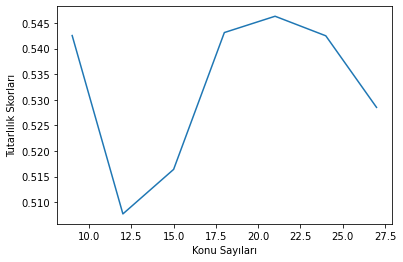

In [77]:
import matplotlib.pyplot as plt
plt.plot(num_topics_list,coherence_model_list,"-"),
plt.xlabel("Konu Sayıları")
plt.ylabel("Tutarlılık Skorları")

plt.show()